## Fast.ai Deep Learning 1 Practice - Image segmentation

This notebook is practice for Lesson 3 of the [Fast.ai](https://www.fast.ai) course. It uses the CamVid dataset.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Path('/media/veracrypt3/Cloud/Datasets/camvid/')

In [4]:
labels = path/'labels'
images = path/'images'

In [5]:
fnames = get_image_files(images)

lbl_names = get_image_files(labels)

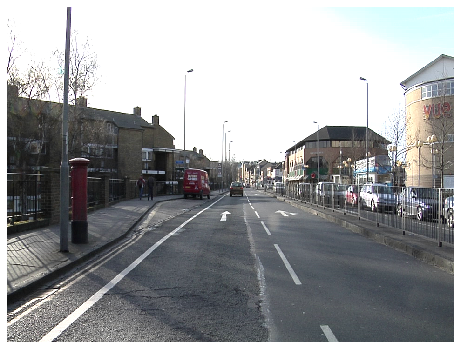

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(8,8))

In [7]:
get_y_fn = lambda x: labels/f'{x.stem}_P{x.suffix}'

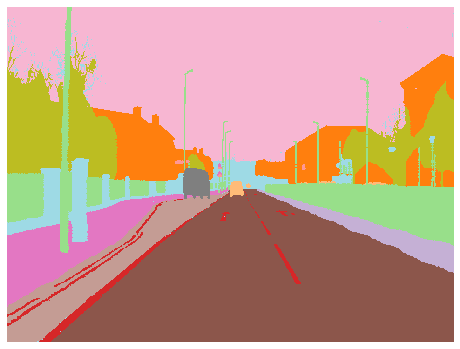

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(8,8), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [18, 18, 18,  ..., 17, 17, 17],
          [18, 18, 18,  ..., 17, 17, 17],
          [18, 18, 18,  ..., 17, 17, 17]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 10808MB of GPU RAM free


In [12]:
src = (SegmentationItemList.from_folder(images)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

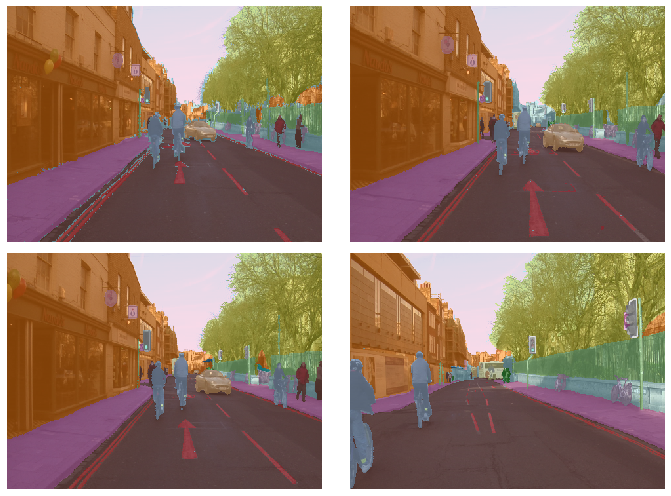

In [14]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics = acc_camvid

In [17]:
wd = 1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch     train_loss  valid_loss  acc_camvid  time    
0         14.224730   #na#        00:47       
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/home/user/anaconda3/envs/deep-learning/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


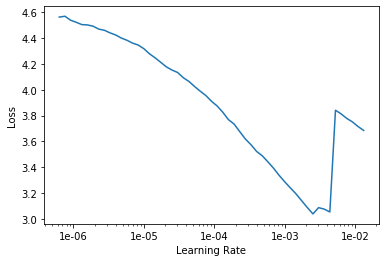

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr = 3e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch     train_loss  valid_loss  acc_camvid  time    
0         1.301998    0.817751    0.805884    00:48     
1         0.877015    0.774938    0.817167    00:45     
2         0.717102    0.551232    0.844903    00:45     
3         0.693126    0.573756    0.847941    00:45     
4         0.627188    0.494374    0.865694    00:45     
5         0.584408    0.454856    0.865284    00:46     
6         0.564534    0.405286    0.892969    00:46     
7         0.570038    0.516012    0.871659    00:45     
8         0.532285    0.463534    0.884281    00:45     
9         0.450965    0.346681    0.898614    00:45     


In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

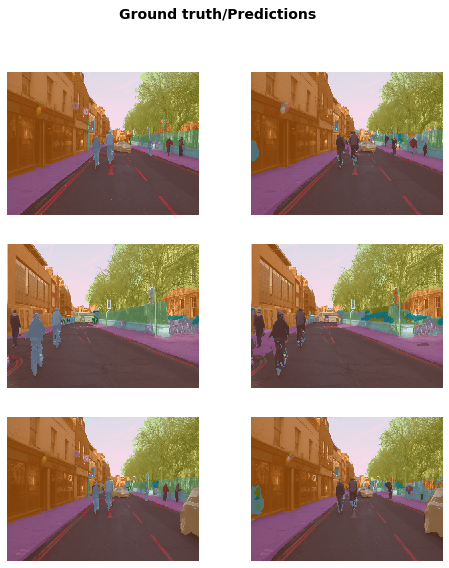

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400, lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch     train_loss  valid_loss  acc_camvid  time    
0         0.380319    0.334076    0.900281    00:48     
1         0.378209    0.338706    0.902952    00:47     
2         0.364253    0.318805    0.905796    00:47     
3         0.356063    0.311726    0.910602    00:47     
4         0.344584    0.327990    0.903537    00:48     
5         0.331579    0.284650    0.923044    00:47     
6         0.315329    0.324054    0.905424    00:48     
7         0.324270    0.301935    0.913781    00:47     
8         0.306112    0.287579    0.919088    00:47     
9         0.308344    0.275137    0.923310    00:47     
10        0.280927    0.265457    0.925562    00:47     
11        0.254773    0.256282    0.928556    00:47     


In [31]:
learn.save('stage-2')

In [31]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
if free > 8200: bs = 1
else:           bs = 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this object has been destroyed
using bs=1, have 5129MB of GPU RAM free


In [32]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [34]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


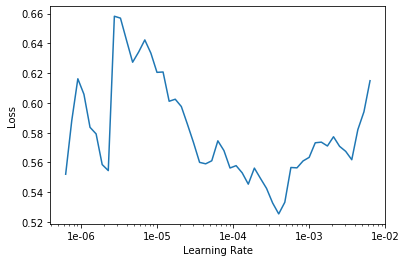

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr = 1e-3

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.452379,0.299539,0.915451,03:09
1,0.420171,0.324073,0.909605,03:16
2,0.357938,0.305425,0.914610,03:04
3,0.399848,0.313684,0.909392,03:05
4,0.368446,0.450727,0.879636,03:03
5,0.412615,0.454352,0.880495,03:03
6,0.391535,0.330749,0.920100,03:05
7,0.362895,0.282261,0.928077,03:03
8,0.294935,0.320923,0.928717,03:04
9,0.239329,0.243293,0.932934,03:04


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big');

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(1e-6, lr/10)

In [42]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.230122,0.246654,0.932434,03:16
1,0.240183,0.242316,0.933541,03:17
2,0.232908,0.231976,0.934333,03:15
3,0.223362,0.233434,0.935806,03:08
4,0.206501,0.248162,0.930454,03:08
5,0.208184,0.240154,0.934802,03:08
6,0.186004,0.250728,0.933048,03:08
7,0.205858,0.245964,0.932277,03:08
8,0.194067,0.243187,0.934438,03:09
9,0.196048,0.244370,0.933260,03:08


In [43]:
learn.save('stage-2-big')

In [45]:
learn.load('stage-2-big');

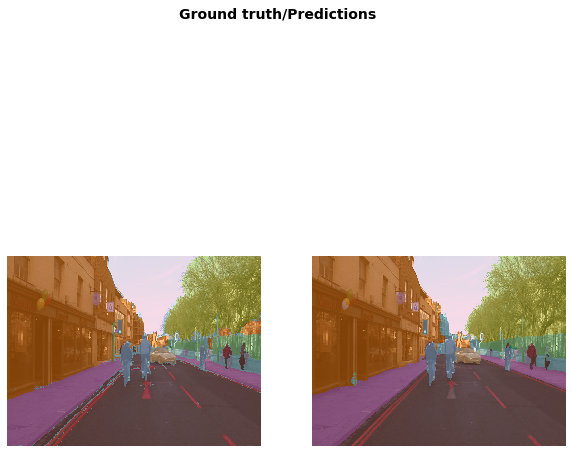

In [53]:
learn.show_results(rows=3, figsize=(10, 10))